# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# the next line provides graphs of better quality on HiDPI screens
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# this is to use progress_apply, read more at https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
# Display the first few rows and basic info about the dataset
df_reviews.head(), df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

(      tconst title_type primary_title original_title  start_year end_year  \
 0  tt0068152      movie             $              $        1971       \N   
 1  tt0068152      movie             $              $        1971       \N   
 2  tt0313150      short          '15'           '15'        2002       \N   
 3  tt0313150      short          '15'           '15'        2002       \N   
 4  tt0313150      short          '15'           '15'        2002       \N   
 
   runtime_minutes  is_adult              genres  average_rating  votes  \
 0             121         0  Comedy,Crime,Drama             6.3   2218   
 1             121         0  Comedy,Crime,Drama             6.3   2218   
 2              25         0  Comedy,Drama,Short             6.3    184   
 3              25         0  Comedy,Drama,Short             6.3    184   
 4              25         0  Comedy,Drama,Short             6.3    184   
 
                                               review  rating   sp  pos  \
 0 

In [6]:
missing_count = df_reviews.isna().sum()
missing_count

tconst             0
title_type         0
primary_title      0
original_title     0
start_year         0
end_year           0
runtime_minutes    0
is_adult           0
genres             0
average_rating     2
votes              2
review             0
rating             0
sp                 0
pos                0
ds_part            0
idx                0
dtype: int64

In [7]:
# Display rows with any missing values
missing_rows = df_reviews[df_reviews.isnull().any(axis=1)]
missing_rows

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


In [8]:
# Dropping the 2 rows with missing values
df_reviews.dropna(inplace=True)
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47329 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47329 non-null  object 
 1   title_type       47329 non-null  object 
 2   primary_title    47329 non-null  object 
 3   original_title   47329 non-null  object 
 4   start_year       47329 non-null  int64  
 5   end_year         47329 non-null  object 
 6   runtime_minutes  47329 non-null  object 
 7   is_adult         47329 non-null  int64  
 8   genres           47329 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47329 non-null  object 
 12  rating           47329 non-null  int64  
 13  sp               47329 non-null  object 
 14  pos              47329 non-null  int64  
 15  ds_part          47329 non-null  object 
 16  idx              47329 non-null  int64  
dtypes: Int64(1),

In [9]:
# Check for duplicates
df_reviews.duplicated().sum()

0

## EDA

Let's check the number of movies and reviews over years.

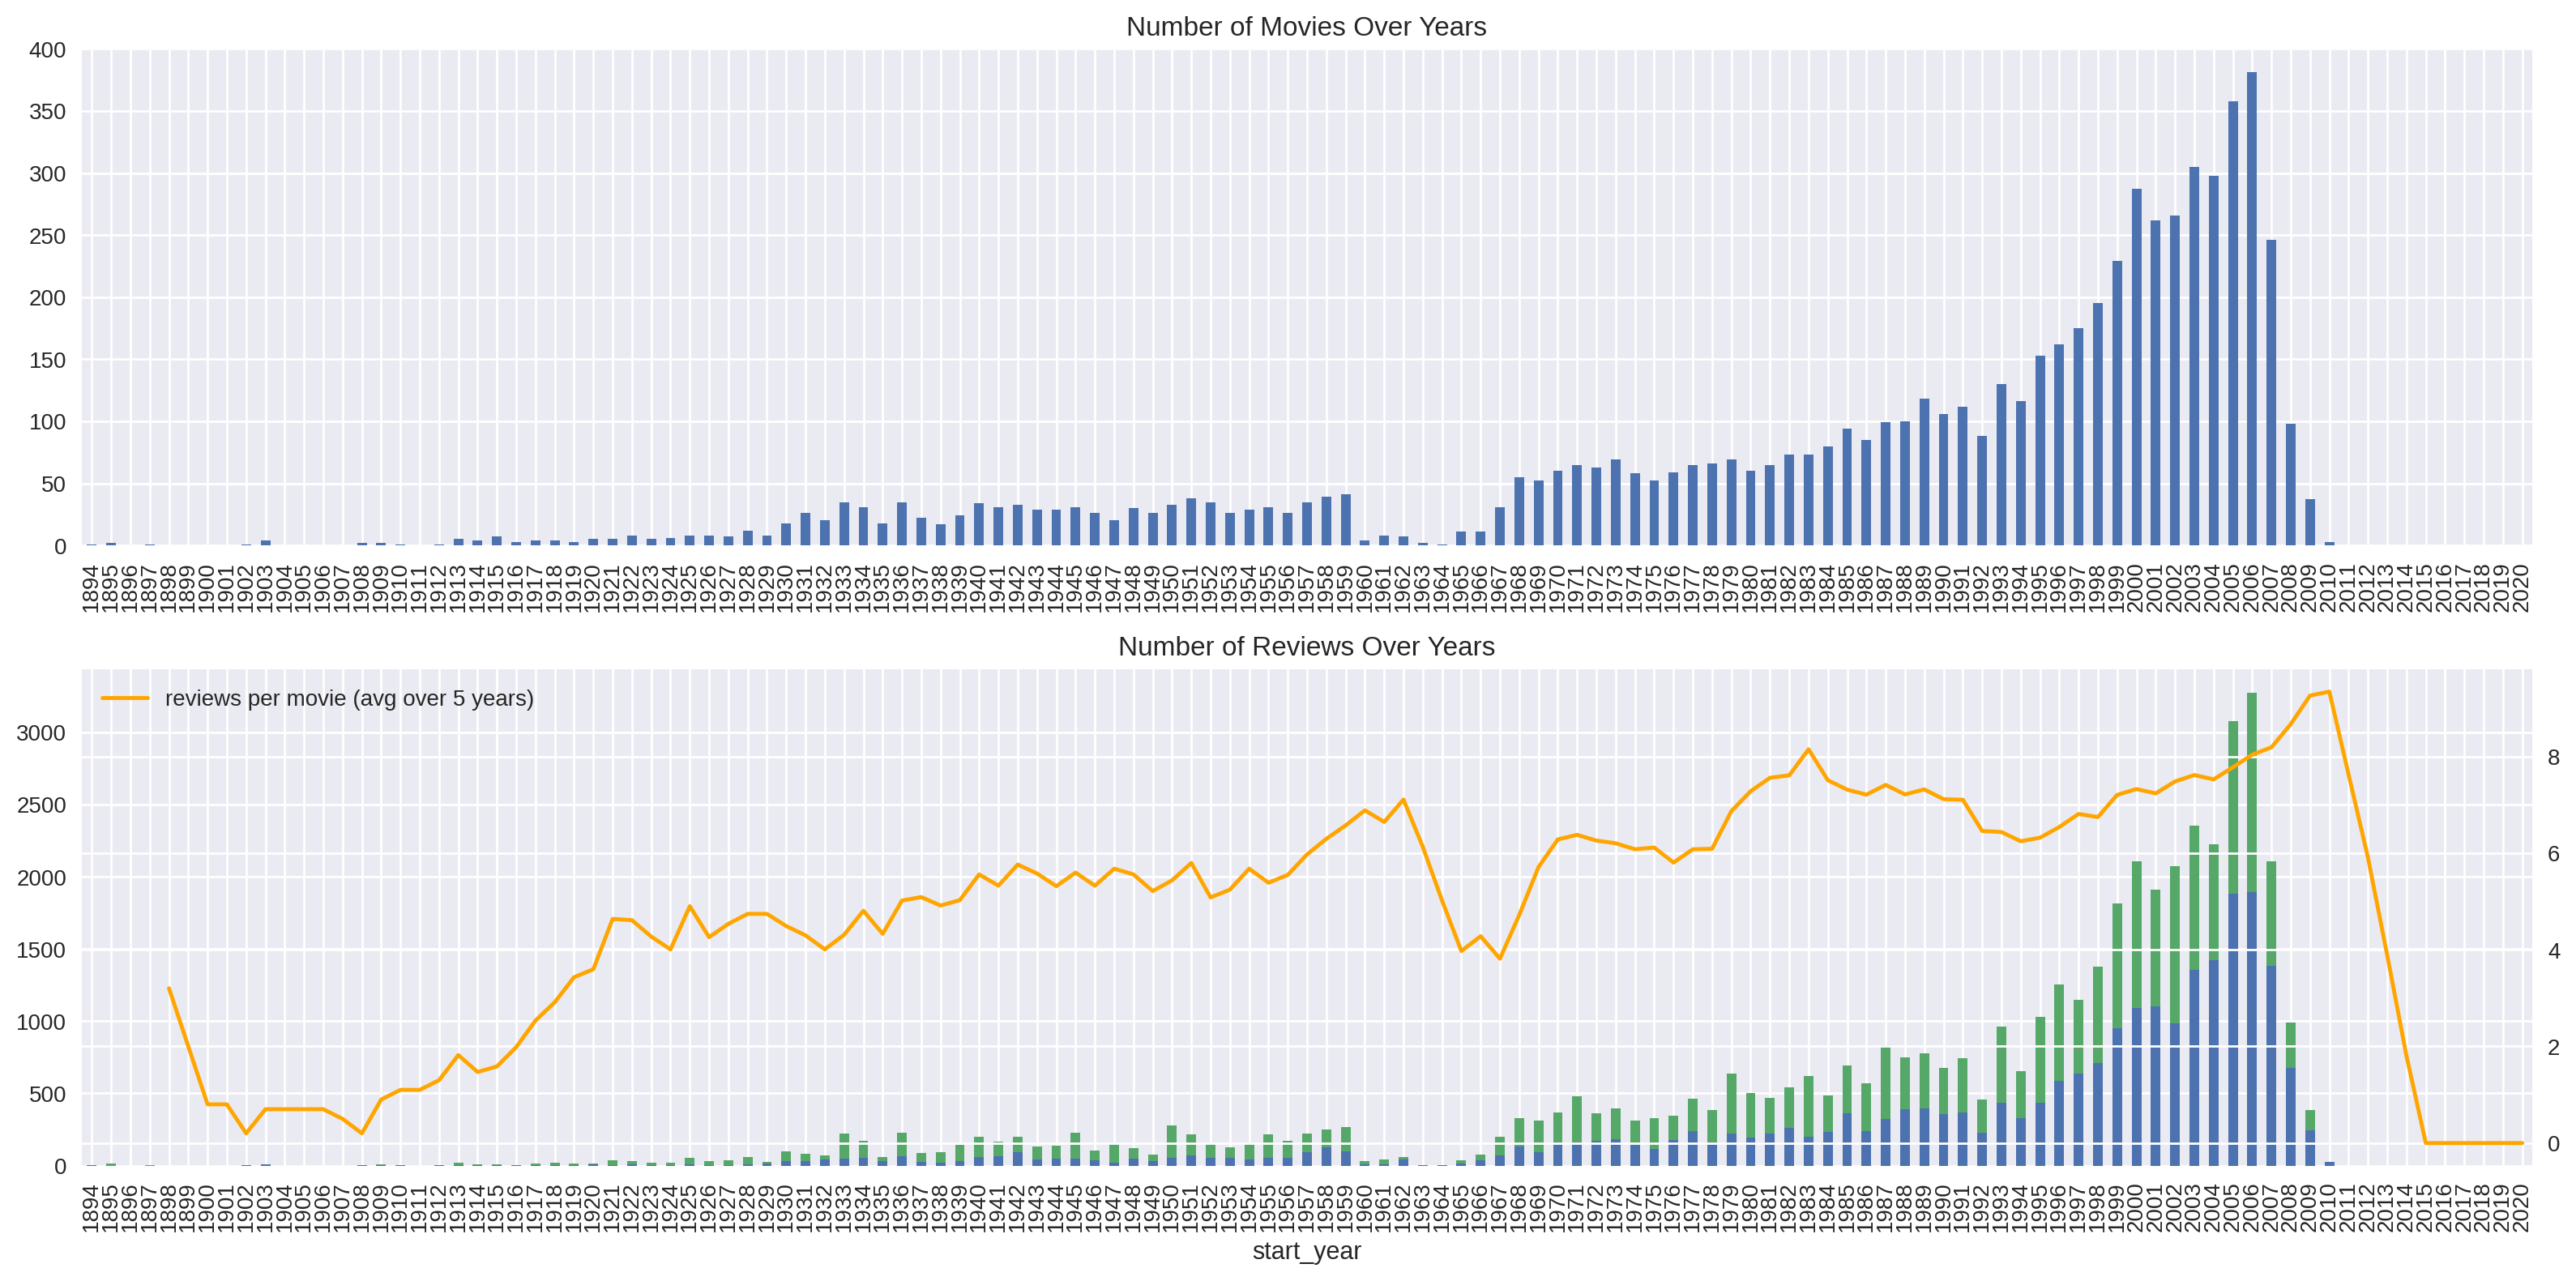

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

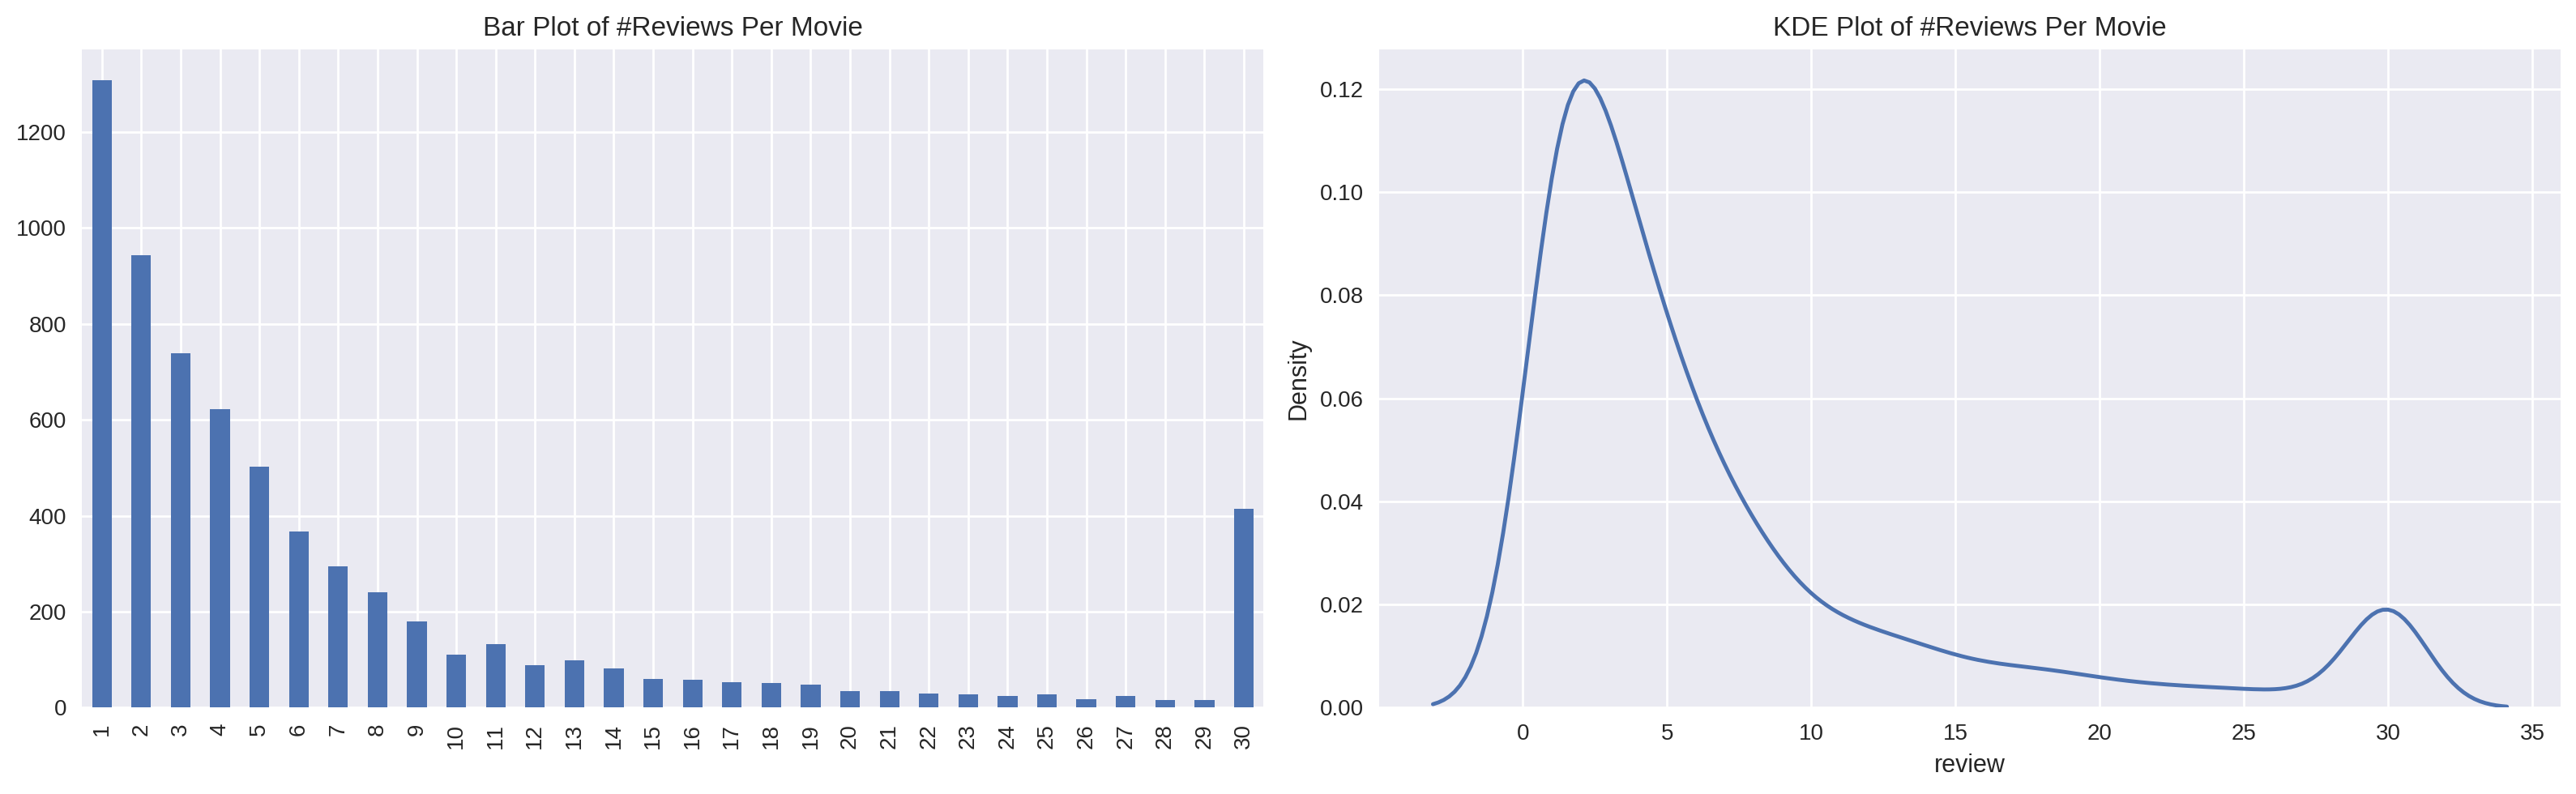

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [12]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

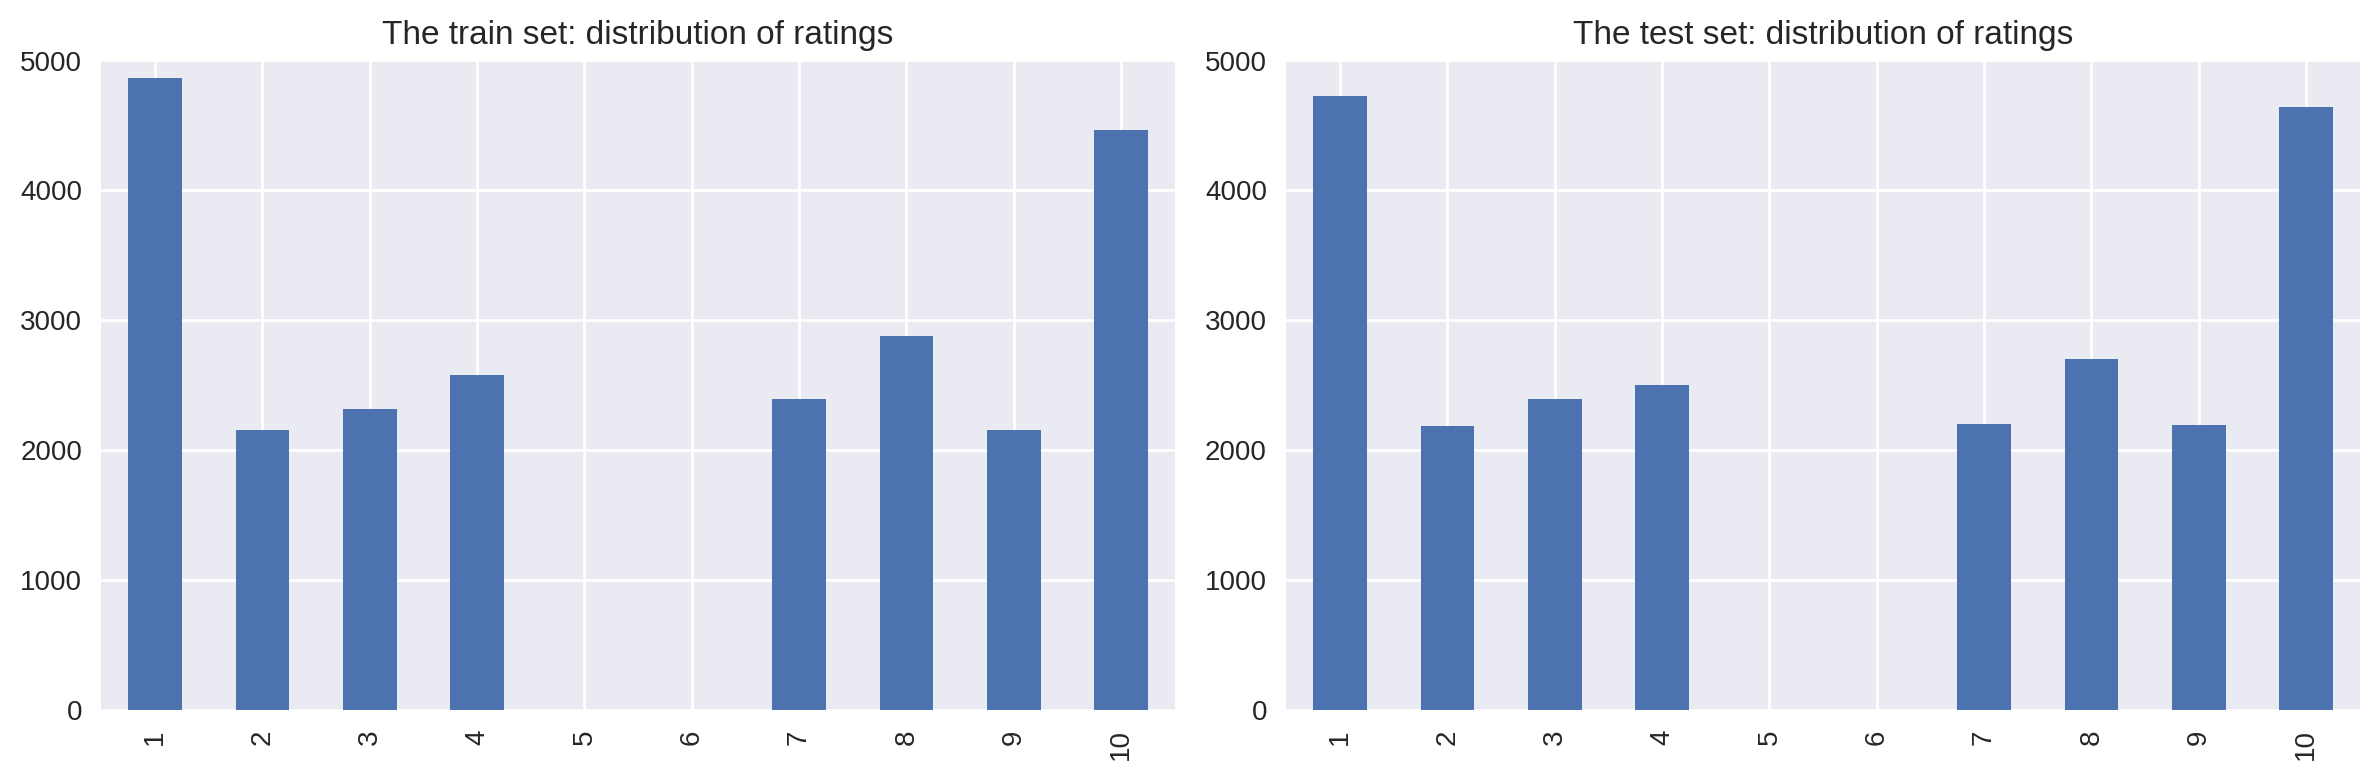

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


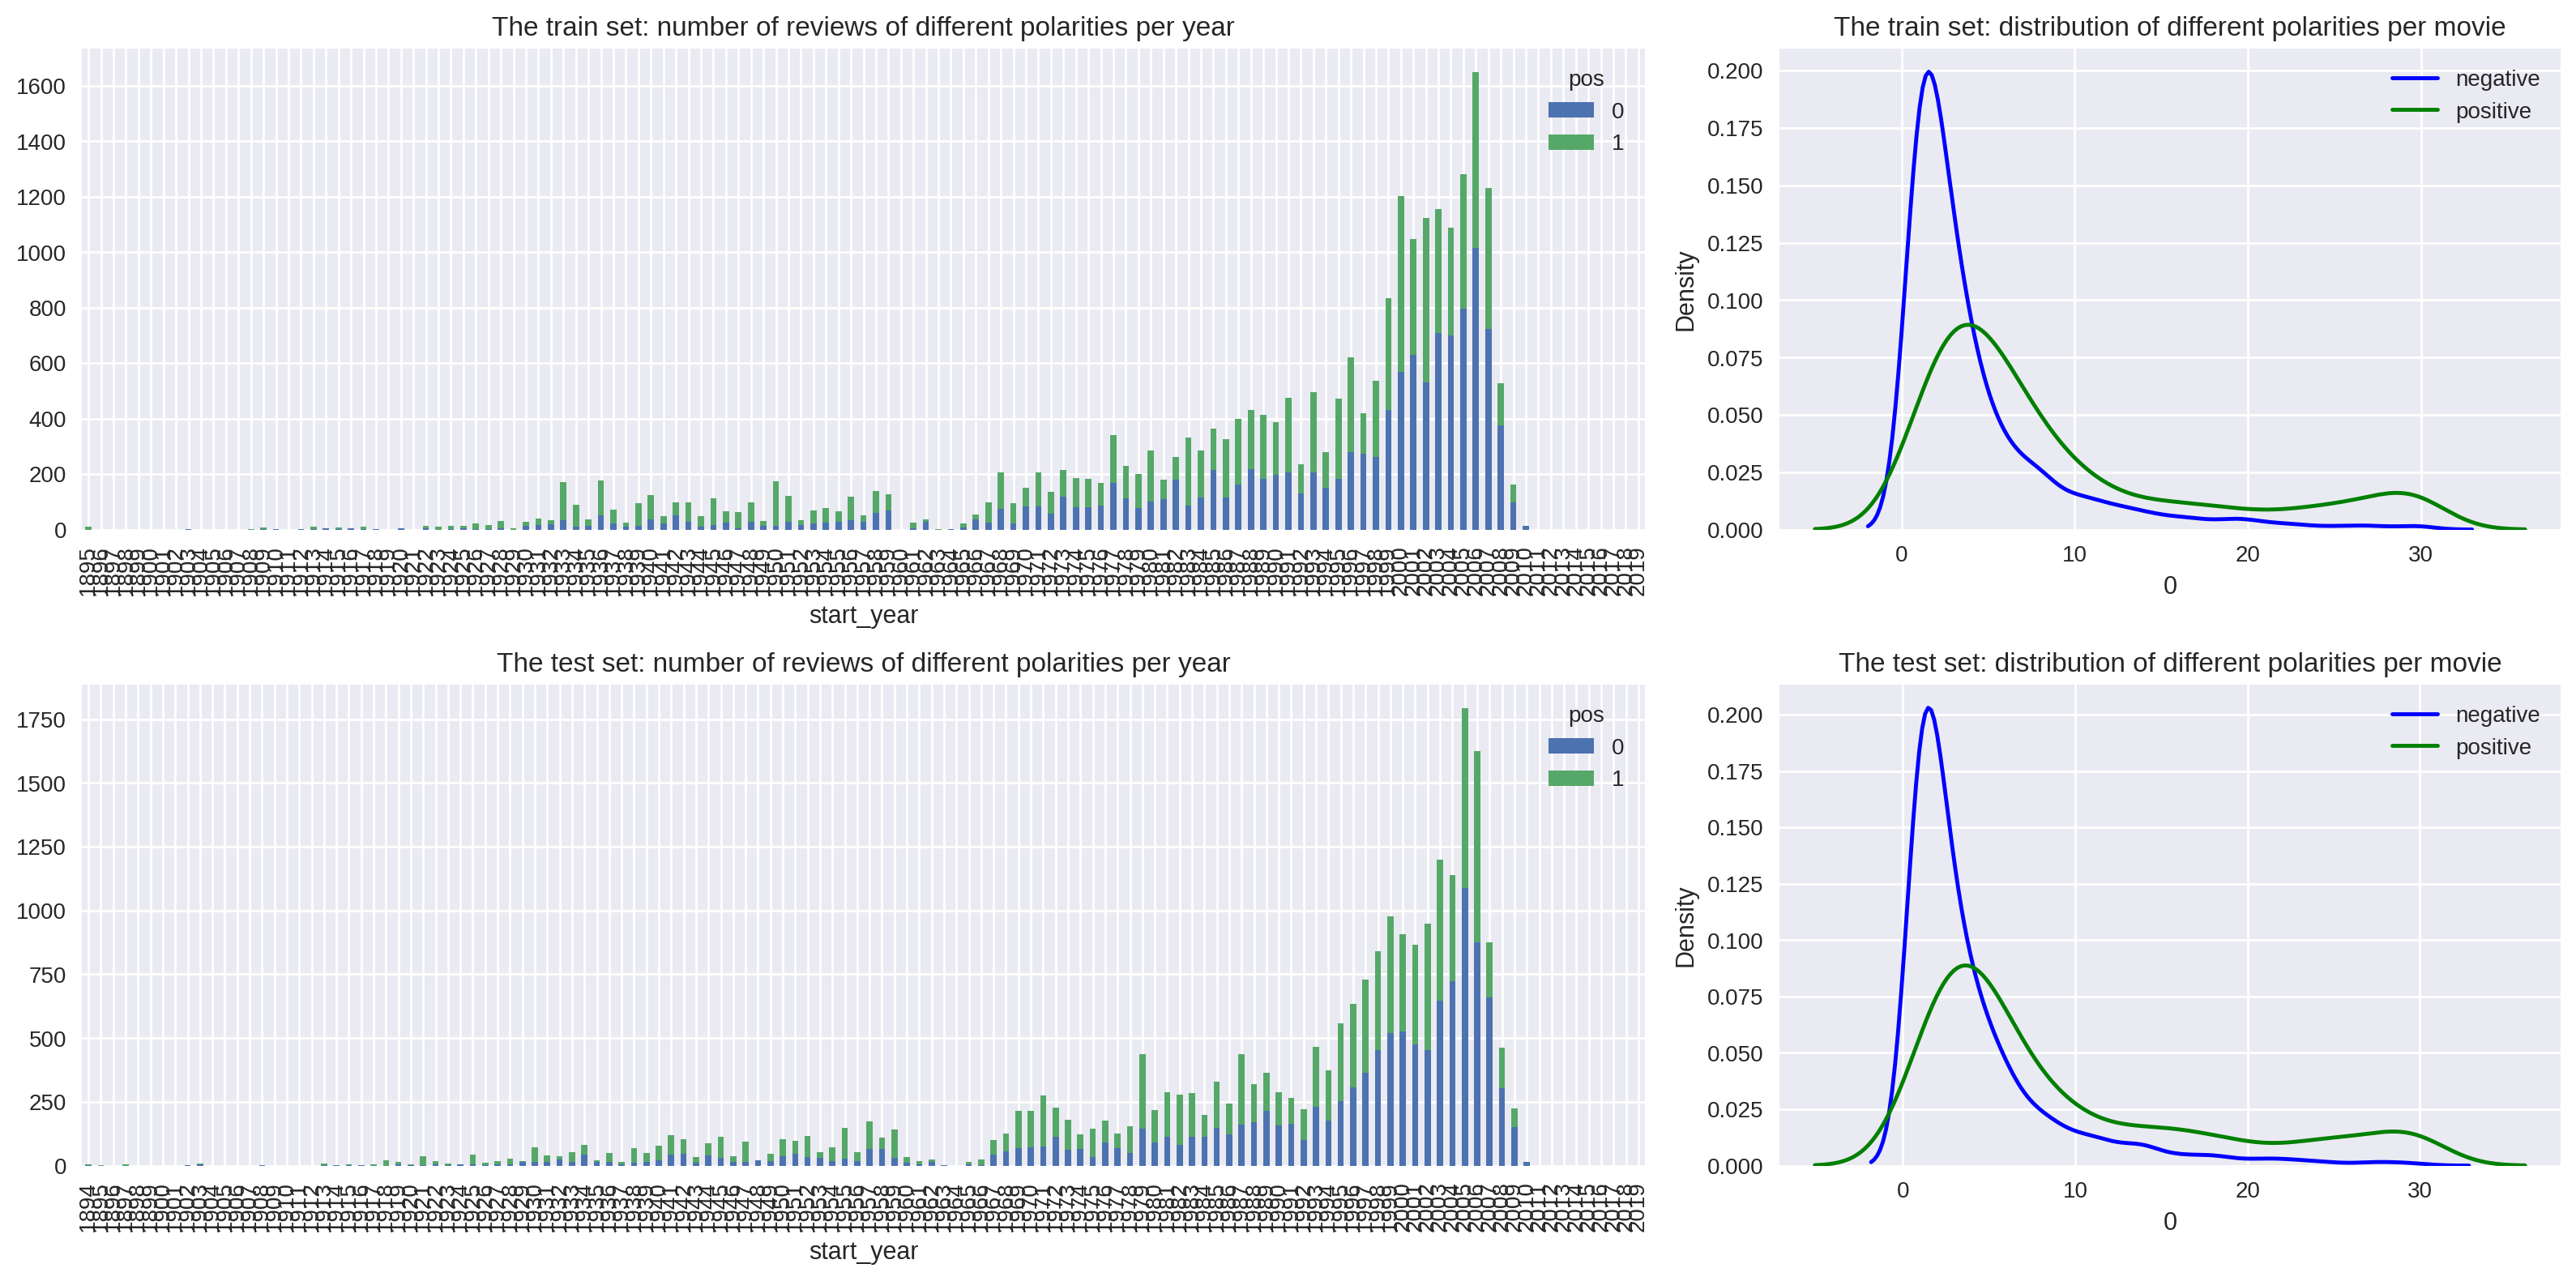

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [15]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [26]:
import re

# Function to normalize text
def normalize_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # remove extra whitespace
    return text

df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text) # <put your code here>

## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [17]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


## Working with models

### Model 0 - Constant

          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


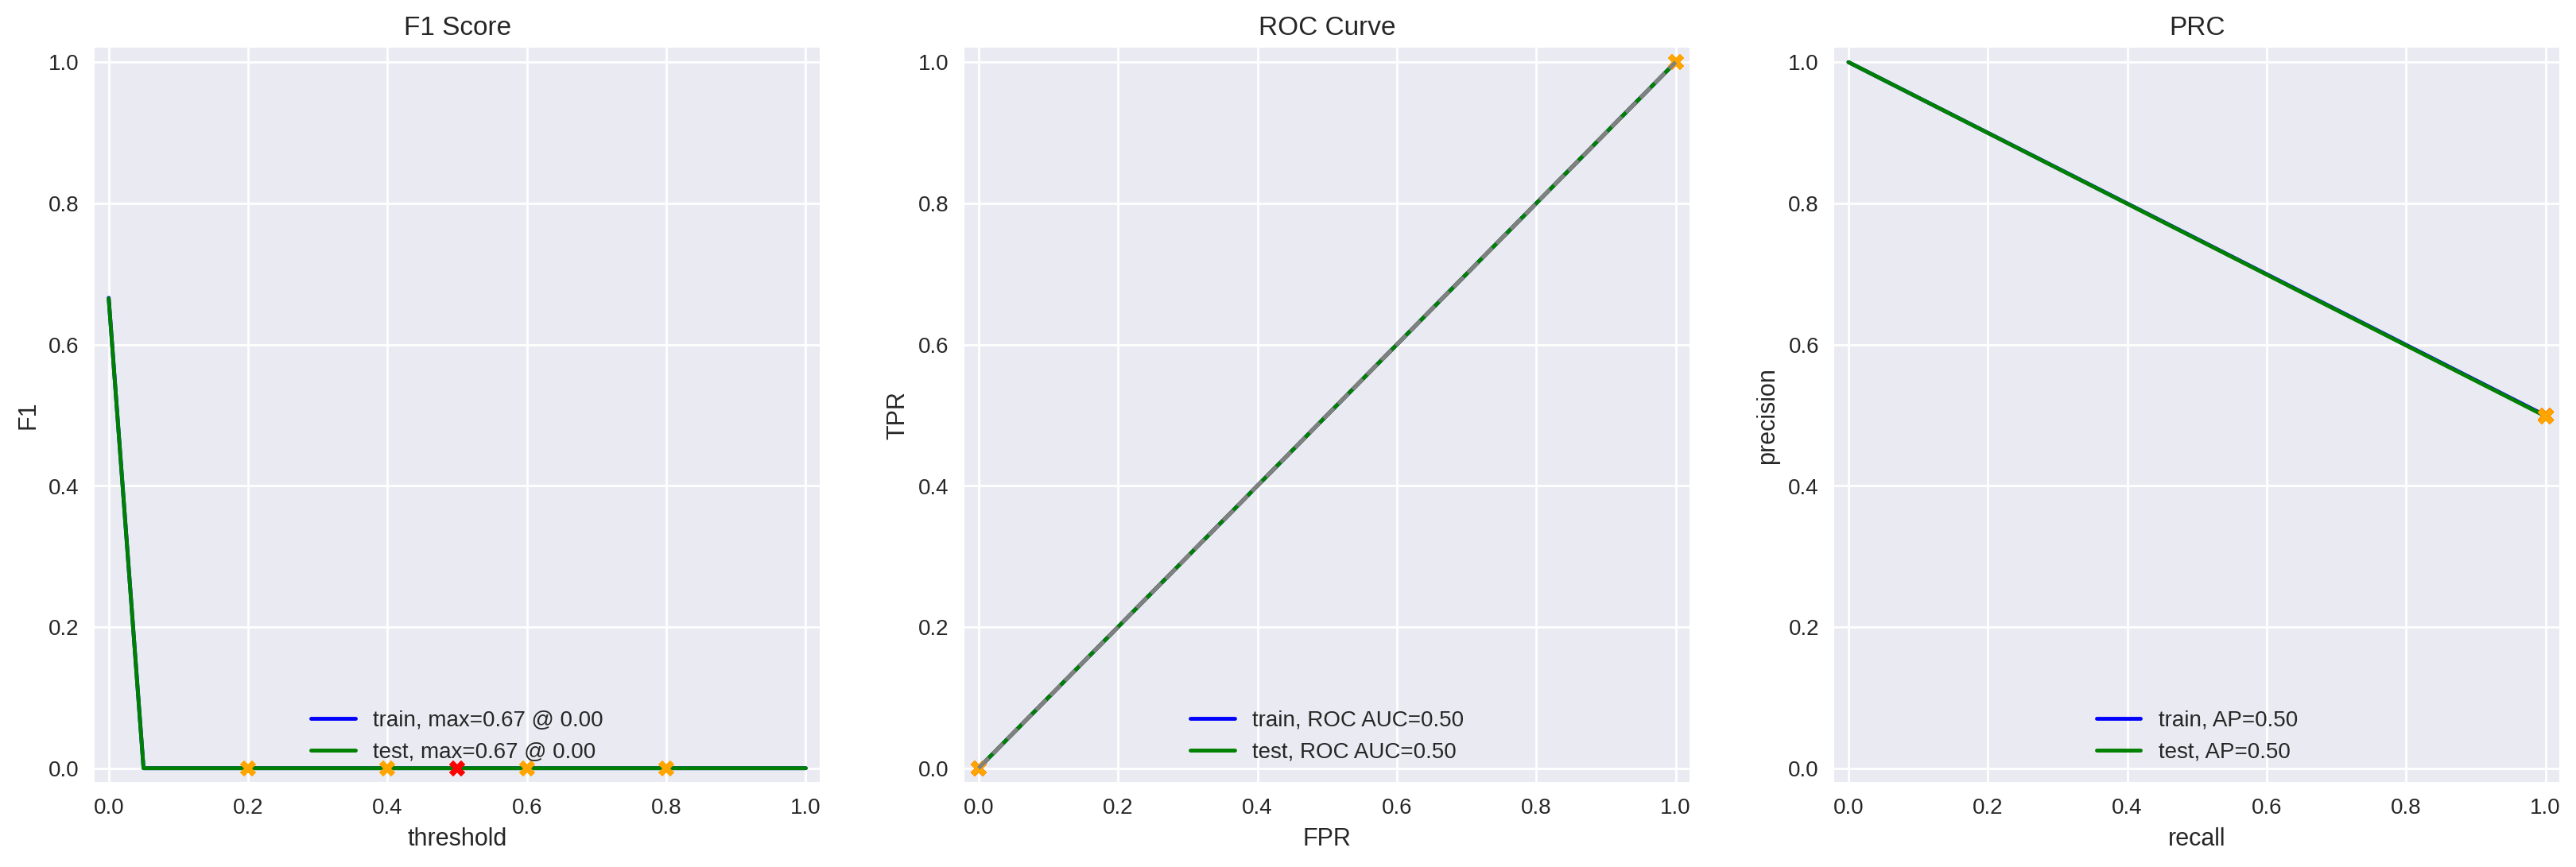

In [19]:
from sklearn.dummy import DummyClassifier


# Initialize the DummyClassifier (always predicts class '0')
model_0 = DummyClassifier(strategy="constant", constant=0)

# Train the model (training dataset)
model_0.fit(df_reviews_train['review_norm'], train_target)

# Evaluate the DummyClassifier using the provided function
evaluate_model(
    model=model_0,
    train_features=df_reviews_train['review_norm'],
    train_target=train_target,
    test_features=df_reviews_test['review_norm'],
    test_target=test_target
)

# from sklearn.metrics import f1_score, classification_report
# # Make predictions - test dataset
# dummy_predictions = dummy_model.predict(df_reviews_test['review_norm'])

# # Evaluate DummyClassifier
# dummy_f1 = f1_score(test_target, dummy_predictions)
# print(f"F1 Score of Model 0 (Constant): {dummy_f1}")

# # Detailed report
# print(classification_report(test_target, dummy_predictions))


**F1 Score**
- F1 score is constant at a low value  (a max of 0.67 at threshold of 0.00). (model always predicts class 0 ).

**ROC Curve**
- ROC curve is a straight diagonal line, and the ROC AUC is 0.50. (indicating no discriminatory power)

**PRC (Precision-Recall Curve)**
- The precision-recall curve shows a declining precision as recall increases, and the average precision score (APS) is 0.50. (indicating of random performance)


Model 0 serves as a baseline, and its performance metrics *(F1 = 0.67, ROC AUC = 0.50, APS = 0.50)* confirm that this is the bare minimum achievable. Moving forward, we aim to train more advanced models to outperform this baseline.

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [29]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


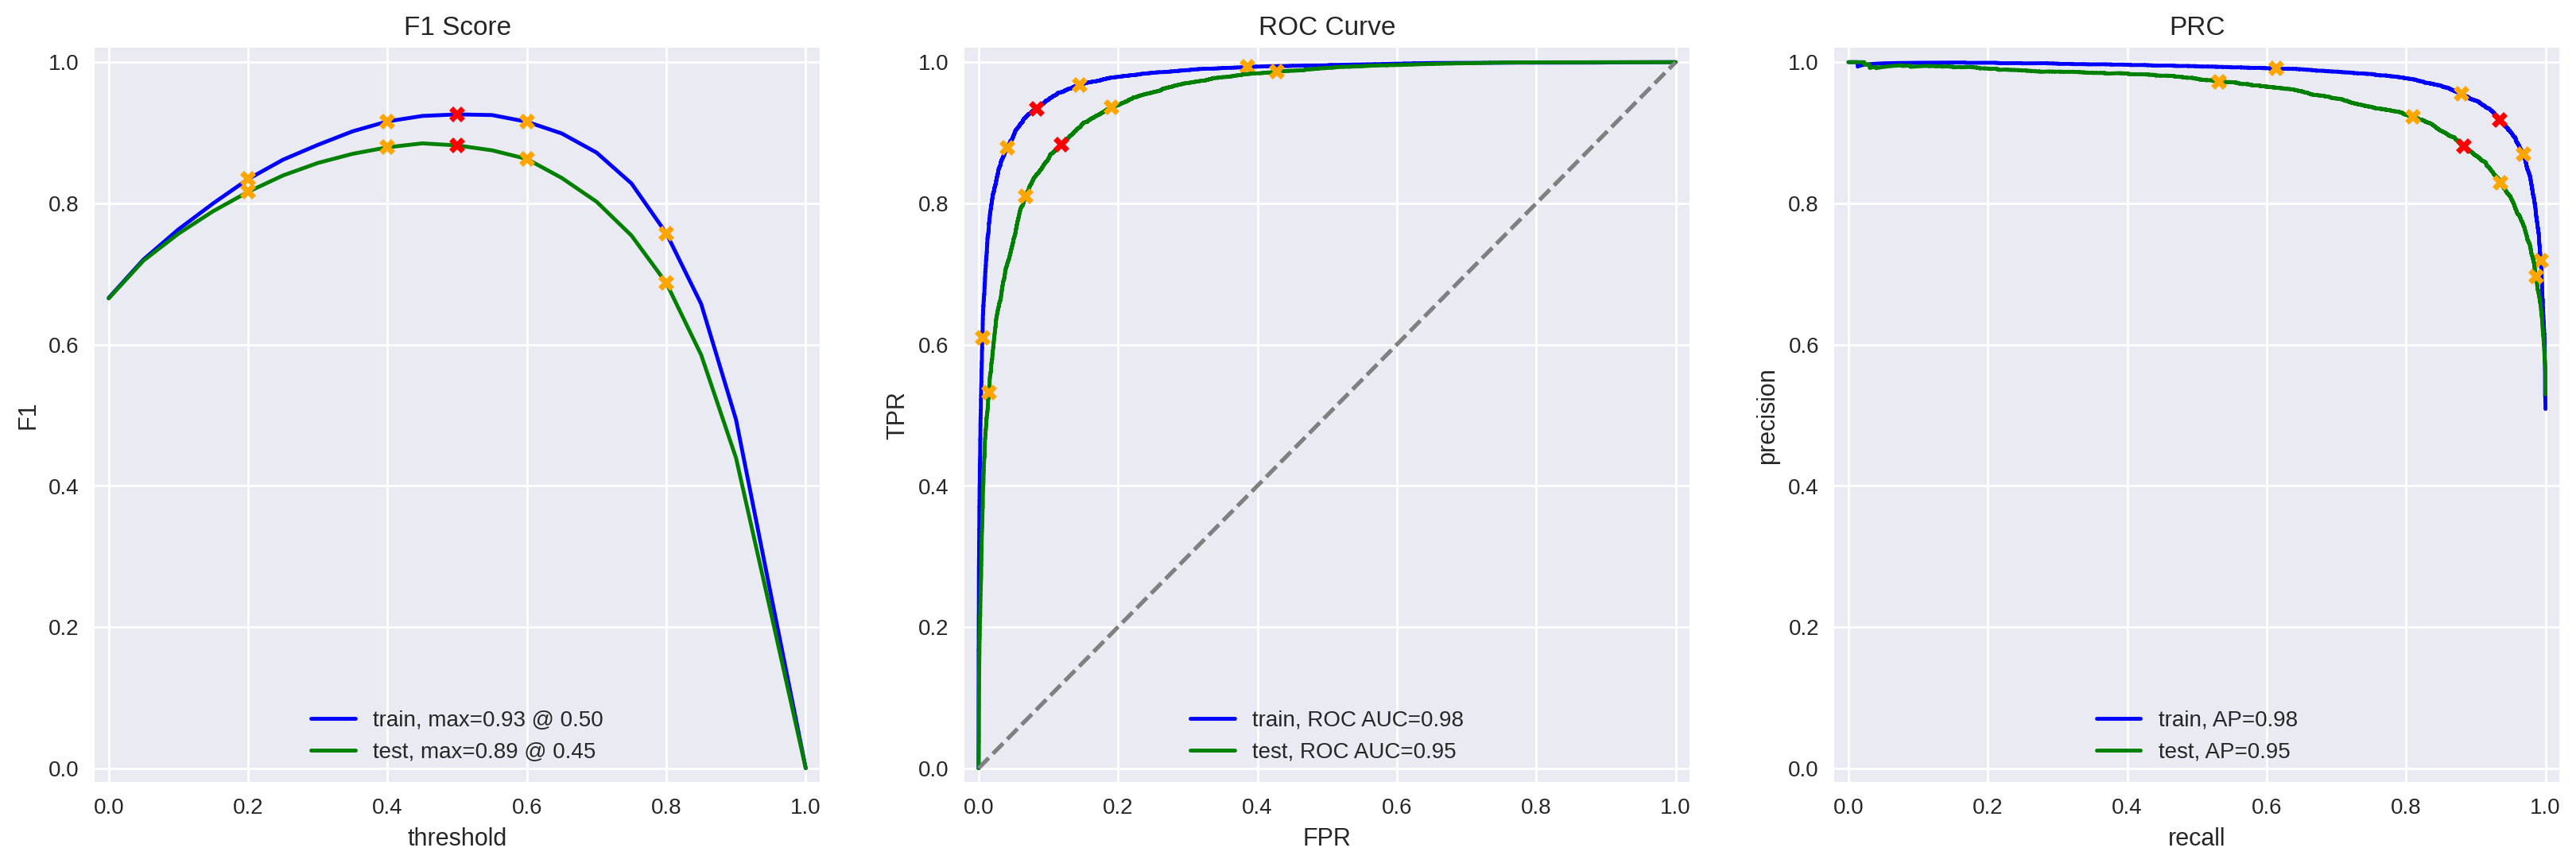

In [30]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Tokenize and remove stopwords
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())  # Tokenize and convert to lowercase
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words]  # Remove stopwords and non-alphabetic tokens
    return ' '.join(filtered_tokens)

# Apply preprocessing
df_reviews_train['review_preprocessed'] = df_reviews_train['review_norm'].apply(preprocess_text)
df_reviews_test['review_preprocessed'] = df_reviews_test['review_norm'].apply(preprocess_text)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=10000)  # Limit to 10k features for efficiency
train_features_1 = tfidf_vectorizer.fit_transform(df_reviews_train['review_preprocessed'])
test_features_1 = tfidf_vectorizer.transform(df_reviews_test['review_preprocessed'])

# LR Model
model_1 = LogisticRegression(max_iter=1000, random_state=42)
model_1.fit(train_features_1, train_target)
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

**Metrics:**
- Train Set:

    - Accuracy: 0.93
    - F1 Score: 0.93
    - ROC AUC: 0.98
    - APS: 0.98


- Test Set:
    - Accuracy: 0.88
    - F1 Score: 0.88
    - ROC AUC: 0.95
    - APS: 0.95
    
    
    
**Performance:**

- The train and test metrics are closely aligned, suggesting the model generalizes well without overfitting.
- An F1 score of 0.88 on the test set is excellent and indicates a good balance between precision and recall.


**High ROC AUC:**
- A score of 0.95 demonstrates that the model is very effective at distinguishing between positive and negative reviews.


**PRC Curve:**
- Precision remains high across varying levels of recall, indicating the model maintains accuracy even when capturing more instances.

### Model 3 - spaCy, TF-IDF and LR

In [38]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [39]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [40]:
df_reviews_train['review_spacy'] = df_reviews_train['review_norm'].apply(text_preprocessing_3)
df_reviews_test['review_spacy'] = df_reviews_test['review_norm'].apply(text_preprocessing_3)

# TF-IDF Vectorization
tfidf_vectorizer_3 = TfidfVectorizer(max_features=10000)  # Limit to 10k features
train_features_3 = tfidf_vectorizer_3.fit_transform(df_reviews_train['review_spacy'])
test_features_3 = tfidf_vectorizer_3.transform(df_reviews_test['review_spacy'])

# Logistic Regression Model
model_3 = LogisticRegression(max_iter=1000, random_state=42)
model_3.fit(train_features_3, train_target)

LogisticRegression(max_iter=1000, random_state=42)

          train  test
Accuracy   0.92  0.88
F1         0.92  0.88
APS        0.97  0.95
ROC AUC    0.97  0.95


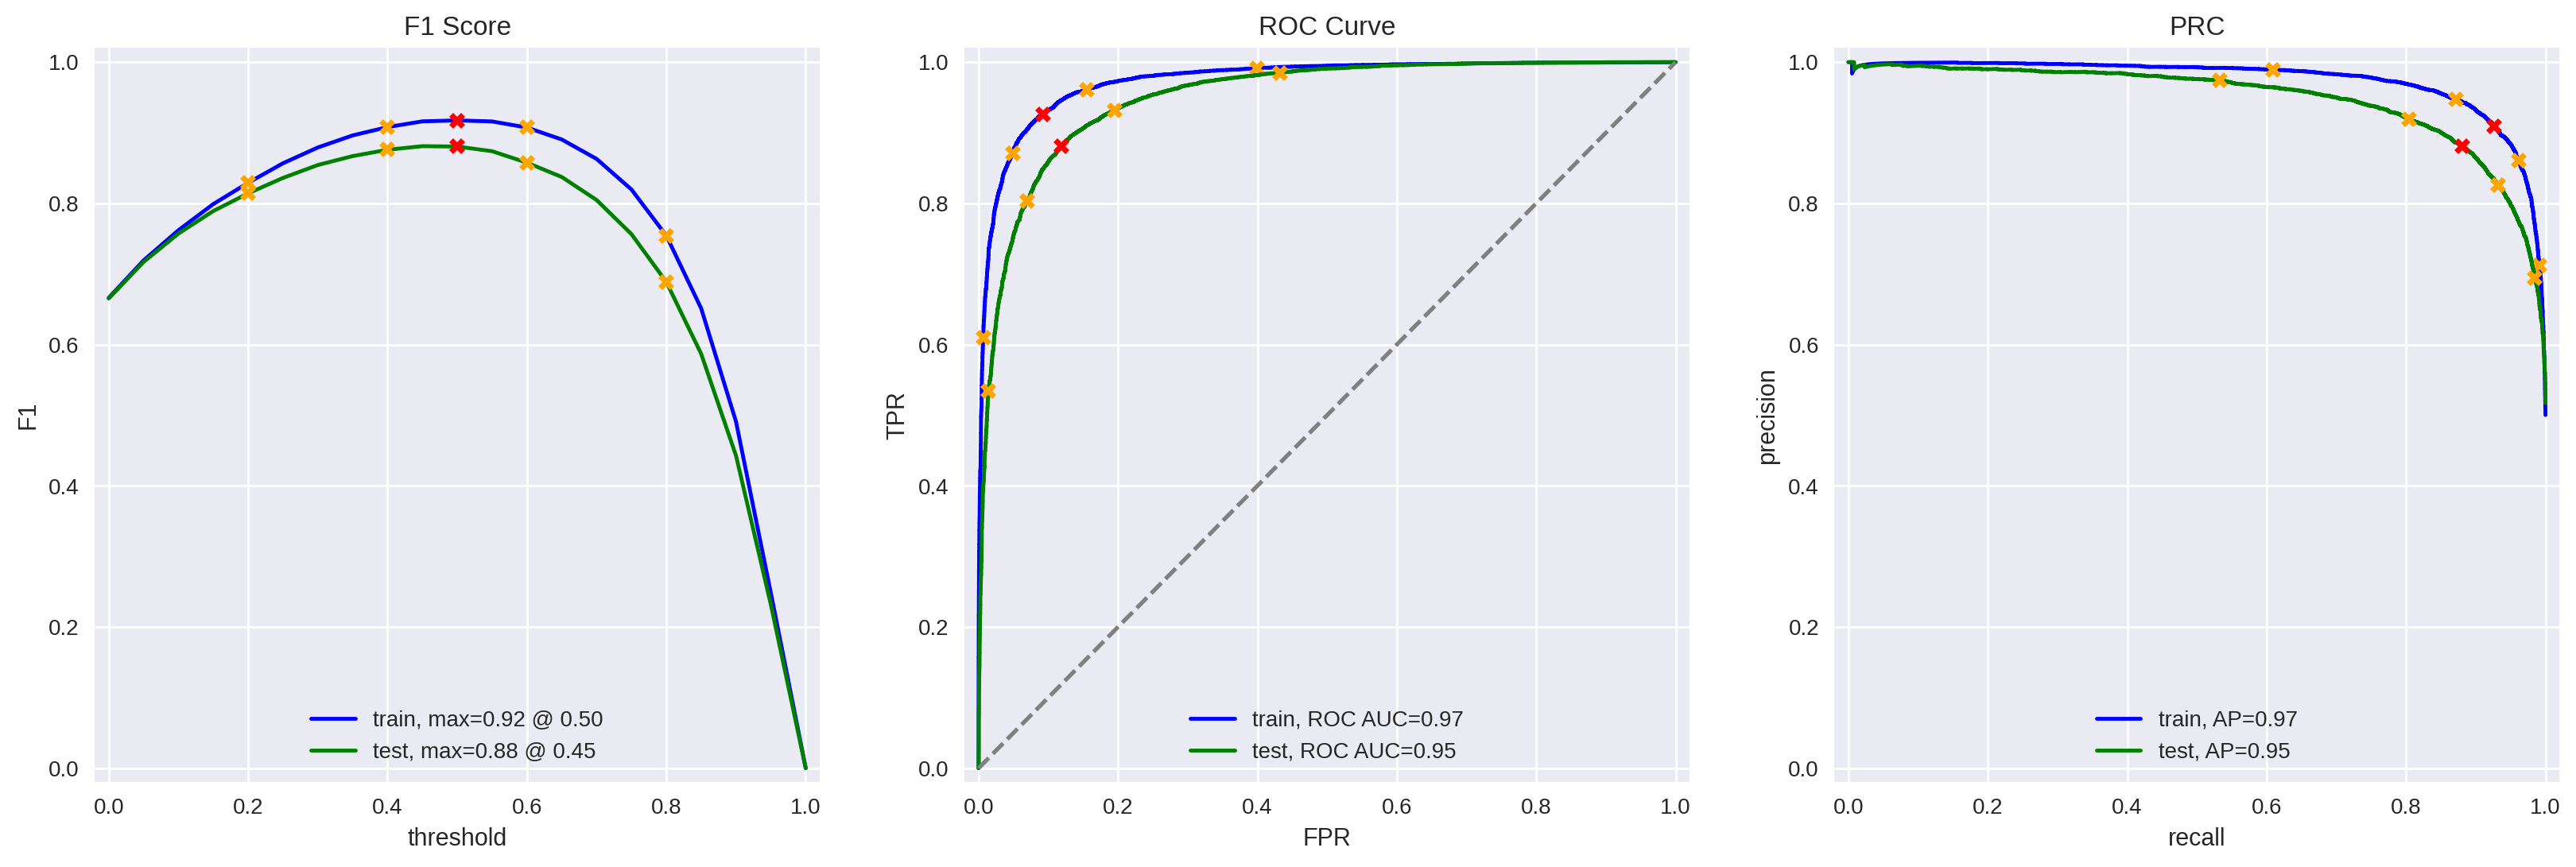

In [37]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

**Metrics:**
- Train Set:

    - Accuracy: 0.92
    - F1 Score: 0.92
    - ROC AUC: 0.97
    - APS: 0.97

- Test Set:
    - Accuracy: 0.88
    - F1 Score: 0.88
    - ROC AUC: 0.95
    - APS: 0.95

**Comparison with Model 1:**

- The metrics are almost identical to Model 1, which indicates that both spaCy and NLTK-based preprocessing pipelines are equally effective for this dataset when paired with TF-IDF and Logistic Regression.

**Slight Overfitting:**

- The train F1 score (0.92) is slightly higher than the test F1 score (0.88), (mild overfitting) and indicates the model is generalizing well.

**High Precision-Recall Consistency:**

- The PRC curve shows strong precision across various recall levels, similar to model 1.


`From our tests, while spaCy preprocessing involves lemmatization and tokenization, it does not show a *distinct* advantage over NLTK's simpler preprocessing pipeline.`

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [42]:
from lightgbm import LGBMClassifier
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Text preprocessing function (reuse from Model 3)
def text_preprocessing_4(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc]
    return ' '.join(tokens)

# Preprocess text using spaCy
df_reviews_train['review_spacy_4'] = df_reviews_train['review_norm'].apply(text_preprocessing_4)
df_reviews_test['review_spacy_4'] = df_reviews_test['review_norm'].apply(text_preprocessing_4)

# TF-IDF Vectorization
tfidf_vectorizer_4 = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), min_df=5, max_df=0.8)
train_features_4 = tfidf_vectorizer_4.fit_transform(df_reviews_train['review_spacy_4'])
test_features_4 = tfidf_vectorizer_4.transform(df_reviews_test['review_spacy_4'])

# Initialize and train the LGBMClassifier
model_4 = LGBMClassifier(
    boosting_type='gbdt',
    n_estimators=100,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
model_4.fit(train_features_4, train_target)

LGBMClassifier(random_state=42)

          train  test
Accuracy   0.93  0.87
F1         0.93  0.87
APS        0.98  0.94
ROC AUC    0.98  0.94


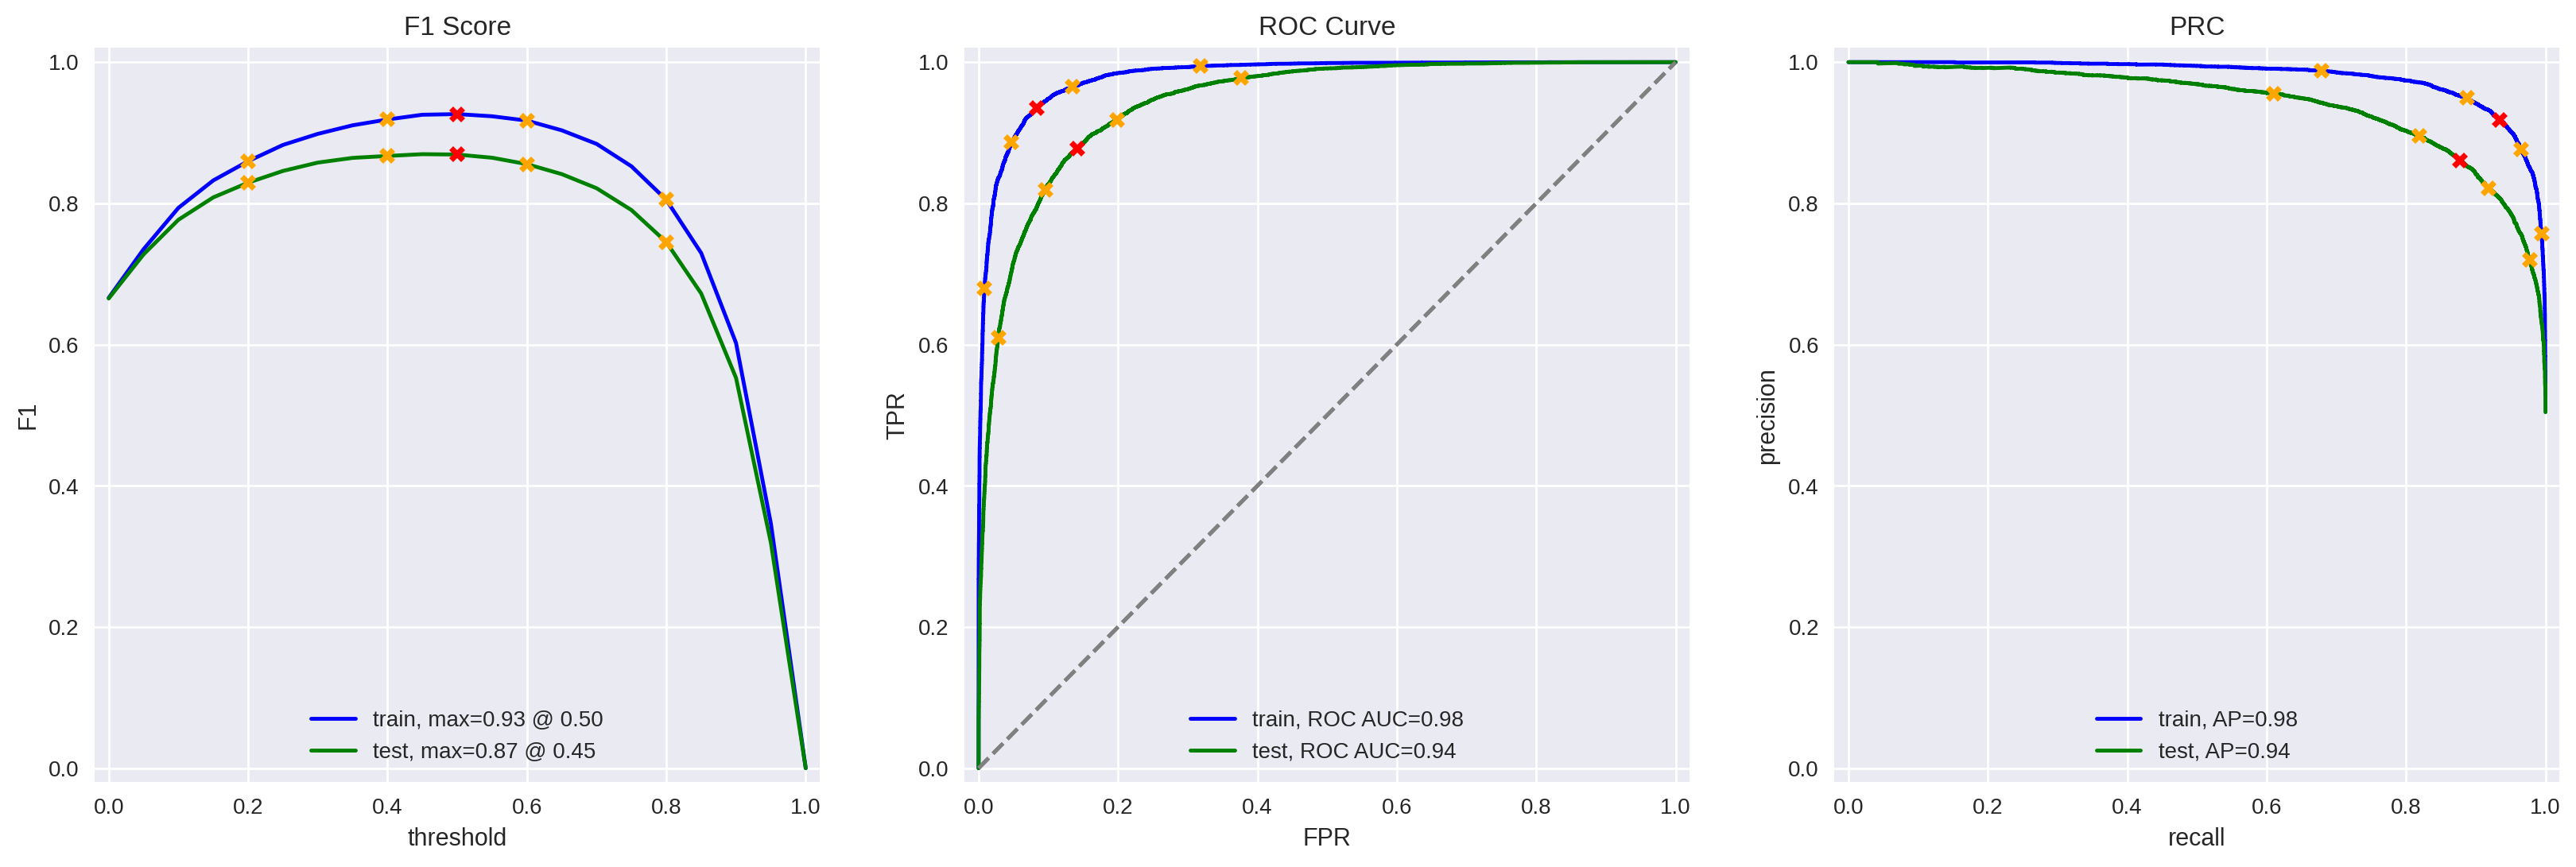

In [23]:
evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)

**Metrics:**
- Train Set:

    - Accuracy: 0.93
    - F1 Score: 0.93
    - ROC AUC: 0.98
    - APS: 0.98

- Test Set:
    - Accuracy: 0.87
    - F1 Score: 0.87
    - ROC AUC: 0.94
    - APS: 0.94

**Train-Test Performance Gap:**

- The train F1 score (0.93) is slightly higher than the test F1 score (0.87), indicative of mild overfitting.

**Comparable ROC AUC:**

- With a ROC AUC of 0.94 on the test set, the model demonstrates strong discriminatory power, similar to models 1 and 3.

**Precision-Recall Curve:**

- The PRC curve shows a slightly less steep decline compared to Models 1 and 3, suggesting that precision drops more as recall increases.


`The results for Model 4 (spaCy, TF-IDF, and LGBMClassifier) indicate strong performance but slightly lower generalization compared to Models 1 and 3`

###  Model 9 - BERT

In [ ]:
import torch
import transformers

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [ ]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    
    # <put your code here to create ids_list and attention_mask_list>
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <put your code here to create attention_mask_batch
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [ ]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [ ]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

In [ ]:
# if you have got the embeddings, it's advisable to save them to have them ready if 
# np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# and load...
# with np.load('features_9.npz') as data:
#     train_features_9 = data['train_features_9']
#     test_features_9 = data['test_features_9']

## My Reviews

In [27]:
# feel free to completely remove these reviews and try your models on your own reviews, those below are just examples

my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = df_reviews['review'].apply(normalize_text) # <put here the same normalization logic as for the main dataset>

my_reviews

,review,review_norm
0,"I did not simply like it, not my kind of movie.",the pakage implies that warren beatty and gold...
1,"Well, I was bored and felt asleep in the middl...",how the hell did they get this made presenting...
2,I was really fascinated with the movie,there is no real story the film seems more lik...
3,Even the actors looked really old and disinter...,um a serious film about troubled teens in sing...
4,I didn't expect the reboot to be so good! Writ...,im totally agree with garryjohal from singapor...
5,"The movie had its upsides and downsides, but I...",this is the first movie ive seen from singapor...
6,What a rotten attempt at a comedy. Not a singl...,yes nonsingaporeans cant see whats the big dea...
7,Launching on Netflix was a brave move & I real...,this true story of carlsons raiders is more of...


### Model 1

In [33]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.05:  the pakage implies that warren beatty and goldie hawn are pulling off a huge bank robbery but thats 
0.10:  how the hell did they get this made presenting itself as a caper comedy the misbegotten is essential
0.37:  there is no real story the film seems more like a fly on the wall dramadocumentary than a proper fil
0.86:  um a serious film about troubled teens in singapore a country i have not much knowledge on but have 
0.75:  im totally agree with garryjohal from singapores comments about this film quotation yes nonsingapore
0.92:  this is the first movie ive seen from singapore and its great if you dont know a lot about asia its 
0.72:  yes nonsingaporeans cant see whats the big deal about this film some of the references in this film 
0.28:  this true story of carlsons raiders is more of a army training film than anything elseobviously thro


0.05:  the pakage implies that warren beatty and goldie hawn are pulling off a huge bank robbery but thats 

0.10:  how the hell did they get this made presenting itself as a caper comedy the misbegotten is essential

0.37:  there is no real story the film seems more like a fly on the wall dramadocumentary than a proper fil

0.86:  um a serious film about troubled teens in singapore a country i have not much knowledge on but have 

0.75:  im totally agree with garryjohal from singapores comments about this film quotation yes nonsingapore

0.92:  this is the first movie ive seen from singapore and its great if you dont know a lot about asia its 

0.72:  yes nonsingaporeans cant see whats the big deal about this film some of the references in this film 

0.28:  this true story of carlsons raiders is more of a army training film than anything elseobviously thro

### Model 3

In [41]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.03:  the pakage implies that warren beatty and goldie hawn are pulling off a huge bank robbery but thats 
0.08:  how the hell did they get this made presenting itself as a caper comedy the misbegotten is essential
0.38:  there is no real story the film seems more like a fly on the wall dramadocumentary than a proper fil
0.76:  um a serious film about troubled teens in singapore a country i have not much knowledge on but have 
0.68:  im totally agree with garryjohal from singapores comments about this film quotation yes nonsingapore
0.97:  this is the first movie ive seen from singapore and its great if you dont know a lot about asia its 
0.88:  yes nonsingaporeans cant see whats the big deal about this film some of the references in this film 
0.24:  this true story of carlsons raiders is more of a army training film than anything elseobviously thro


0.03:  the pakage implies that warren beatty and goldie hawn are pulling off a huge bank robbery but thats 

0.08:  how the hell did they get this made presenting itself as a caper comedy the misbegotten is essential

0.38:  there is no real story the film seems more like a fly on the wall dramadocumentary than a proper fil

0.76:  um a serious film about troubled teens in singapore a country i have not much knowledge on but have 

0.68:  im totally agree with garryjohal from singapores comments about this film quotation yes nonsingapore

0.97:  this is the first movie ive seen from singapore and its great if you dont know a lot about asia its 

0.88:  yes nonsingaporeans cant see whats the big deal about this film some of the references in this film 

0.24:  this true story of carlsons raiders is more of a army training film than anything elseobviously thro

### Model 4

In [43]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.62:  the pakage implies that warren beatty and goldie hawn are pulling off a huge bank robbery but thats 
0.68:  how the hell did they get this made presenting itself as a caper comedy the misbegotten is essential
0.65:  there is no real story the film seems more like a fly on the wall dramadocumentary than a proper fil
0.62:  um a serious film about troubled teens in singapore a country i have not much knowledge on but have 
0.65:  im totally agree with garryjohal from singapores comments about this film quotation yes nonsingapore
0.47:  this is the first movie ive seen from singapore and its great if you dont know a lot about asia its 
0.73:  yes nonsingaporeans cant see whats the big deal about this film some of the references in this film 
0.68:  this true story of carlsons raiders is more of a army training film than anything elseobviously thro


### Model 9

In [743]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.21:  i did not simply like it  not my kind of movie 
0.01:  well  i was bored and felt asleep in the middle of the movie 
0.99:  i was really fascinated with the movie
0.00:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.21:  i didn t expect the reboot to be so good  writers really cared about the source material
0.94:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.09:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.96:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


## Conclusions

**Models**

- **Model 1 vs. Model 3:**
    - Both models achieve almost identical performance metrics, with Model 1 slightly ahead in F1 and ROC AUC scores.
    - Model 1 is simpler (uses NLTK preprocessing), whereas Model 3 leverages spaCy, which introduces complexity without a significant performance boost.

- **Model 4:**

    - This model uses LGBMClassifier, which is more powerful than Logistic Regression for some tasks.
    - However, its test F1 score (0.87) is slightly lower than Models 1 and 3, indicating marginally poorer generalization.
    - The added computational cost of training and tuning LGBMClassifier does **not** translate to any meaningful improvements in this case.

**Custom Reviews:**

- Model 1 and Model 3 provide similar probability outputs, reflecting their aligned performance.
- Model 4 exhibits slightly higher probabilities for positive predictions, which might indicate overfitting or a higher sensitivity to positive sentiment.

**Model Recommendation** 

**Model 1 (NLTK, TF-IDF, Logistic Regression):**

- Simplicity: Easier to implement and maintain due to simpler preprocessing (NLTK).
- Performance: Achieves the best generalization (Test F1 = 0.88, ROC AUC = 0.95), matching or slightly outperforming the other models.
- Efficiency: Faster training and prediction times compared to spaCy and LGBM-based models.
- Scalability: LR is highly interpretable and computationally efficient for large datasets allowing for easy scalability in futrue